#1. Peparación de los datos

In [34]:
##Importar lebrerías
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE




##Extracción del Archivo Tratado

In [35]:
##Leer datos


df_clientes = pd.read_csv('/content/datos_tratados.csv')

df_clientes.head()


,Abandono,Genero,Es_Jubilado,Tiene_Pareja,Tiene_Dependientes,Meses_Contratado,Suscripcion_Telefono,Suscripcion_Multiples_Lineas,Proovedor_Servicio_Internet,Suscripcion_Seguridad_Online,Suscripcion_Backup_Online,Suscripcion_Proteccion_Dispositivos,Suscripcion_Soporte_Tecnico,Suscripcion_StreamingTV,Suscripcion_StreamingMovies,Tipo_Contrato,Metodo_Pago,Facturacion_Mensual,Facturacion_Total,Cuentas_Diarias
0,no,femenino,no,si,si,9,si,no,dsl,no,si,no,si,si,no,un año,recibo correo,65.6,593.30,2.186667
1,no,masculino,no,no,no,9,si,si,dsl,no,no,no,no,no,si,mensual,recibo correo,59.9,542.40,1.996667
2,si,masculino,no,no,no,4,si,no,fibra optica,no,no,si,no,no,no,mensual,recibo electronico,73.9,280.85,2.463333
3,si,masculino,si,si,no,13,si,no,fibra optica,no,si,si,no,si,si,mensual,recibo electronico,98.0,1237.85,3.266667
4,si,femenino,si,si,no,3,si,no,fibra optica,no,no,no,si,si,no,mensual,recibo correo,83.9,267.40,2.796667


## Eliminación de Columnas Irrelevantes

In [36]:
##Revisar columnas con un solo valor único
cols_unicas = [col for col in df_clientes.columns if df_clientes[col].nunique() <= 1]

##Revisar columnas con alta correlación (>0.95) para eliminar redundancia (solo numéricas)
corr_matrix = df_clientes.select_dtypes(include=['number']).corr().abs()
cols_correlacion = [
    col for col in corr_matrix.columns
    if any(corr_matrix[col].drop(col) > 0.95)
]

##Revisar columnas con más del 50% de valores nulos
cols_nulas = [col for col in df_clientes.columns if df_clientes[col].isna().mean() > 0.5]

##Consolidar posibles columnas a eliminar
posibles_eliminar = set(cols_unicas + cols_correlacion + cols_nulas)

##Mostrar resultados
{
    "Columnas_sin_variabilidad": cols_unicas,
    "Columnas_muy_correlacionadas": cols_correlacion,
    "Columnas_muy_incompletas": cols_nulas,
    "Sugerencia_final": list(posibles_eliminar)
}



{'Columnas_sin_variabilidad': [],
 'Columnas_muy_correlacionadas': ['Facturacion_Mensual', 'Cuentas_Diarias'],
 'Columnas_muy_incompletas': [],
 'Sugerencia_final': ['Facturacion_Mensual', 'Cuentas_Diarias']}

In [37]:
##Eliminar columnas sugeridas
df_clientes = df_clientes.drop(columns=list(posibles_eliminar), errors='ignore')

##Confirmar cambios
df_clientes.head()


,Abandono,Genero,Es_Jubilado,Tiene_Pareja,Tiene_Dependientes,Meses_Contratado,Suscripcion_Telefono,Suscripcion_Multiples_Lineas,Proovedor_Servicio_Internet,Suscripcion_Seguridad_Online,Suscripcion_Backup_Online,Suscripcion_Proteccion_Dispositivos,Suscripcion_Soporte_Tecnico,Suscripcion_StreamingTV,Suscripcion_StreamingMovies,Tipo_Contrato,Metodo_Pago,Facturacion_Total
0,no,femenino,no,si,si,9,si,no,dsl,no,si,no,si,si,no,un año,recibo correo,593.30
1,no,masculino,no,no,no,9,si,si,dsl,no,no,no,no,no,si,mensual,recibo correo,542.40
2,si,masculino,no,no,no,4,si,no,fibra optica,no,no,si,no,no,no,mensual,recibo electronico,280.85
3,si,masculino,si,si,no,13,si,no,fibra optica,no,si,si,no,si,si,mensual,recibo electronico,1237.85
4,si,femenino,si,si,no,3,si,no,fibra optica,no,no,no,si,si,no,mensual,recibo correo,267.40


##Encoding

In [38]:


##Detectar todas las columnas categóricas (incluye Abandono)
cat_cols = df_clientes.select_dtypes(include=['object', 'category']).columns

##Inicializar OneHotEncoder (drop solo si es binaria)
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False, dtype=np.int64)

##Ajustar y transformar el DataFrame completo
ohe_array = ohe.fit_transform(df_clientes[cat_cols])

##Crear DataFrame con columnas codificadas
ohe_df = pd.DataFrame(ohe_array, columns=ohe.get_feature_names_out(cat_cols), index=df_clientes.index)

##Unir con las columnas numéricas originales
num_cols = df_clientes.select_dtypes(exclude=['object', 'category']).columns
df_clientes_encoded = pd.concat([ohe_df, df_clientes[num_cols]], axis=1)

df_clientes_encoded.head()



,Abandono_si,Genero_masculino,Es_Jubilado_si,Tiene_Pareja_si,Tiene_Dependientes_si,Suscripcion_Telefono_si,Suscripcion_Multiples_Lineas_si,Proovedor_Servicio_Internet_dsl,Proovedor_Servicio_Internet_fibra optica,Proovedor_Servicio_Internet_no,...,Suscripcion_StreamingMovies_si,Tipo_Contrato_dos años,Tipo_Contrato_mensual,Tipo_Contrato_un año,Metodo_Pago_recibo correo,Metodo_Pago_recibo electronico,Metodo_Pago_tarjeta de credito,Metodo_Pago_transferencia bancaria,Meses_Contratado,Facturacion_Total
0,0,0,0,1,1,1,0,1,0,0,...,0,0,0,1,1,0,0,0,9,593.30
1,0,1,0,0,0,1,1,1,0,0,...,1,0,1,0,1,0,0,0,9,542.40
2,1,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,4,280.85
3,1,1,1,1,0,1,0,0,1,0,...,1,0,1,0,0,1,0,0,13,1237.85
4,1,0,1,1,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,3,267.40


##Verificación de la Proporción de Cancelación (Churn)

In [39]:
##Calcular la proporción de clientes que cancelaron vs. los que permanecen
churn_counts = df_clientes_encoded['Abandono_si'].value_counts(normalize=True)
churn_abs = df_clientes_encoded['Abandono_si'].value_counts()

##Mostrar resultados
print("\nProporción:\n", churn_counts)
print("Valores absolutos:\n", churn_abs)



Proporción:
 Abandono_si
0    0.734215
1    0.265785
Name: proportion, dtype: float64
Valores absolutos:
 Abandono_si
0    5163
1    1869
Name: count, dtype: int64


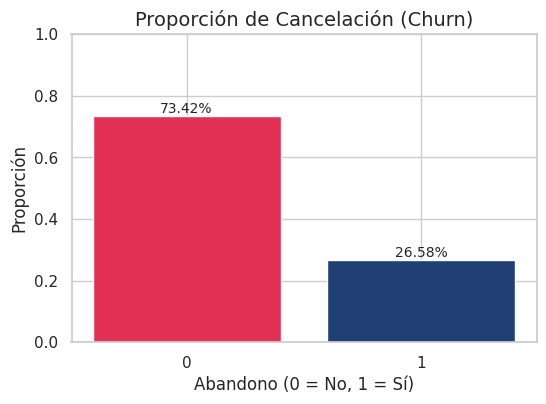

In [40]:


##Gráfico de barras
plt.figure(figsize=(6, 4))
bars = plt.bar(churn_counts.index.astype(str), churn_counts.values, color=["#e23155", "#203f75"])
plt.title("Proporción de Cancelación (Churn)", fontsize=14)
plt.xlabel("Abandono (0 = No, 1 = Sí)")
plt.ylabel("Proporción")
plt.ylim(0, 1)

##Etiquetas encima de las barras
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f"{bar.get_height():.2%}",
             ha='center', va='bottom', fontsize=10)

plt.show()

**Nota:** sí hay desvalance.

##Balanceo de clases

In [41]:


##Separar variables y objetivo
X = df_clientes_encoded.drop(columns=['Abandono_si'])
y = df_clientes_encoded['Abandono_si']

##Dividir en entrenamiento y prueba (estratificado para mantener proporciones)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

##Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

##Verificar nuevo balance
print("Distribución original en entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución balanceada en entrenamiento:")
print(y_train_bal.value_counts(normalize=True))


Distribución original en entrenamiento:
Abandono_si
0    0.734222
1    0.265778
Name: proportion, dtype: float64

Distribución balanceada en entrenamiento:
Abandono_si
0    0.5
1    0.5
Name: proportion, dtype: float64


#2. Correlación y Selección de Variables

##Análisis de Correlación

Variables más correlacionadas con 'Abandono_si':
 Abandono_si                                 1.000000
Tipo_Contrato_mensual                       0.404565
Meses_Contratado                            0.354049
Proovedor_Servicio_Internet_fibra optica    0.307463
Tipo_Contrato_dos años                      0.301552
Metodo_Pago_recibo electronico              0.301455
Proovedor_Servicio_Internet_no              0.227578
Facturacion_Total                           0.199484
Tipo_Contrato_un año                        0.178225
Suscripcion_Seguridad_Online_si             0.171270
Name: Abandono_si, dtype: float64


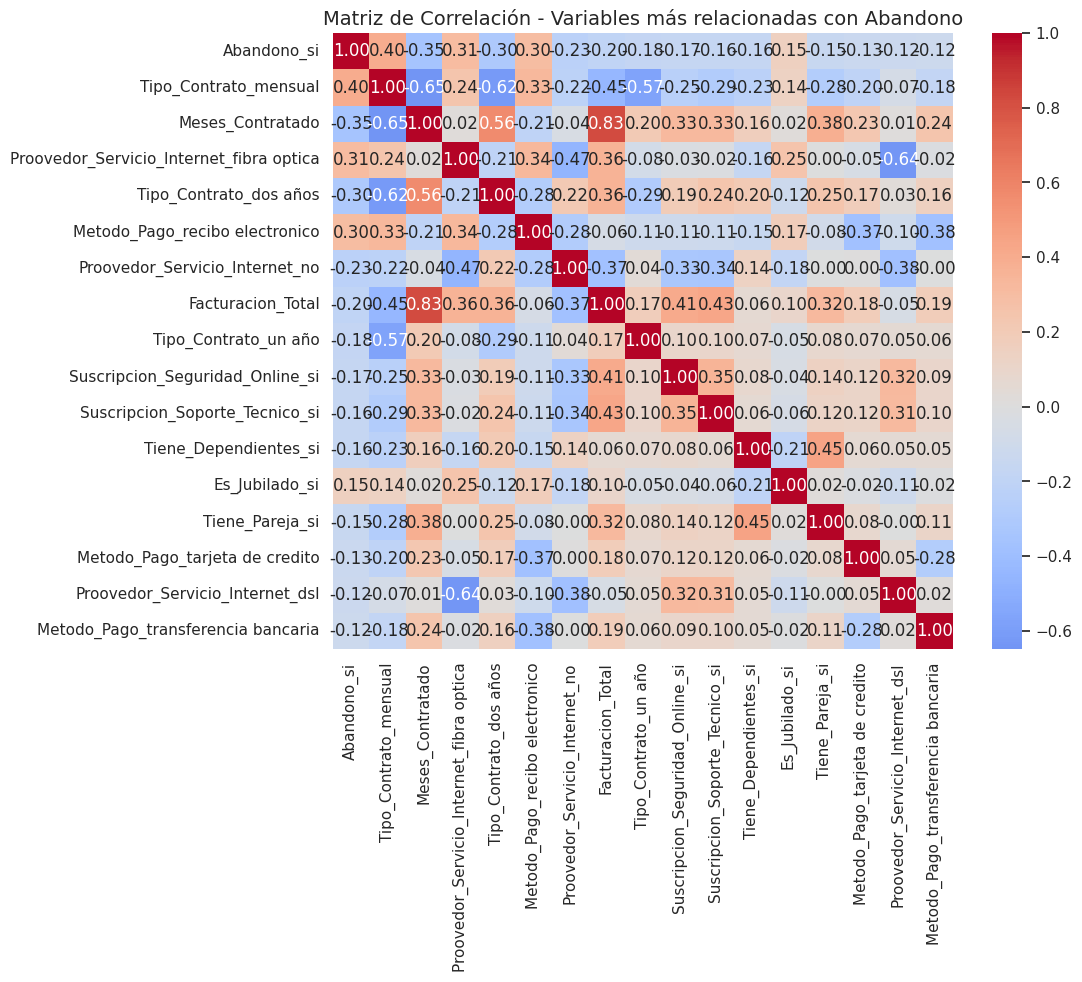

In [42]:


##Calcular la matriz de correlación
corr_matrix = df_clientes_encoded.corr()

##Seleccionar las variables más correlacionadas con 'Abandono_si' (umbral de 0.1 para relevancia)
corr_target = corr_matrix['Abandono_si'].abs().sort_values(ascending=False)
top_features = corr_target[corr_target > 0.1].index

##Mostrar las 10 variables más correlacionadas
print("Variables más correlacionadas con 'Abandono_si':\n", corr_target.head(10))

##Crear una matriz de correlación solo con estas variables
focused_corr = df_clientes_encoded[top_features].corr()

##Graficar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(focused_corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Matriz de Correlación - Variables más relacionadas con Abandono', fontsize=14)
plt.show()


##Análisis Dirigido

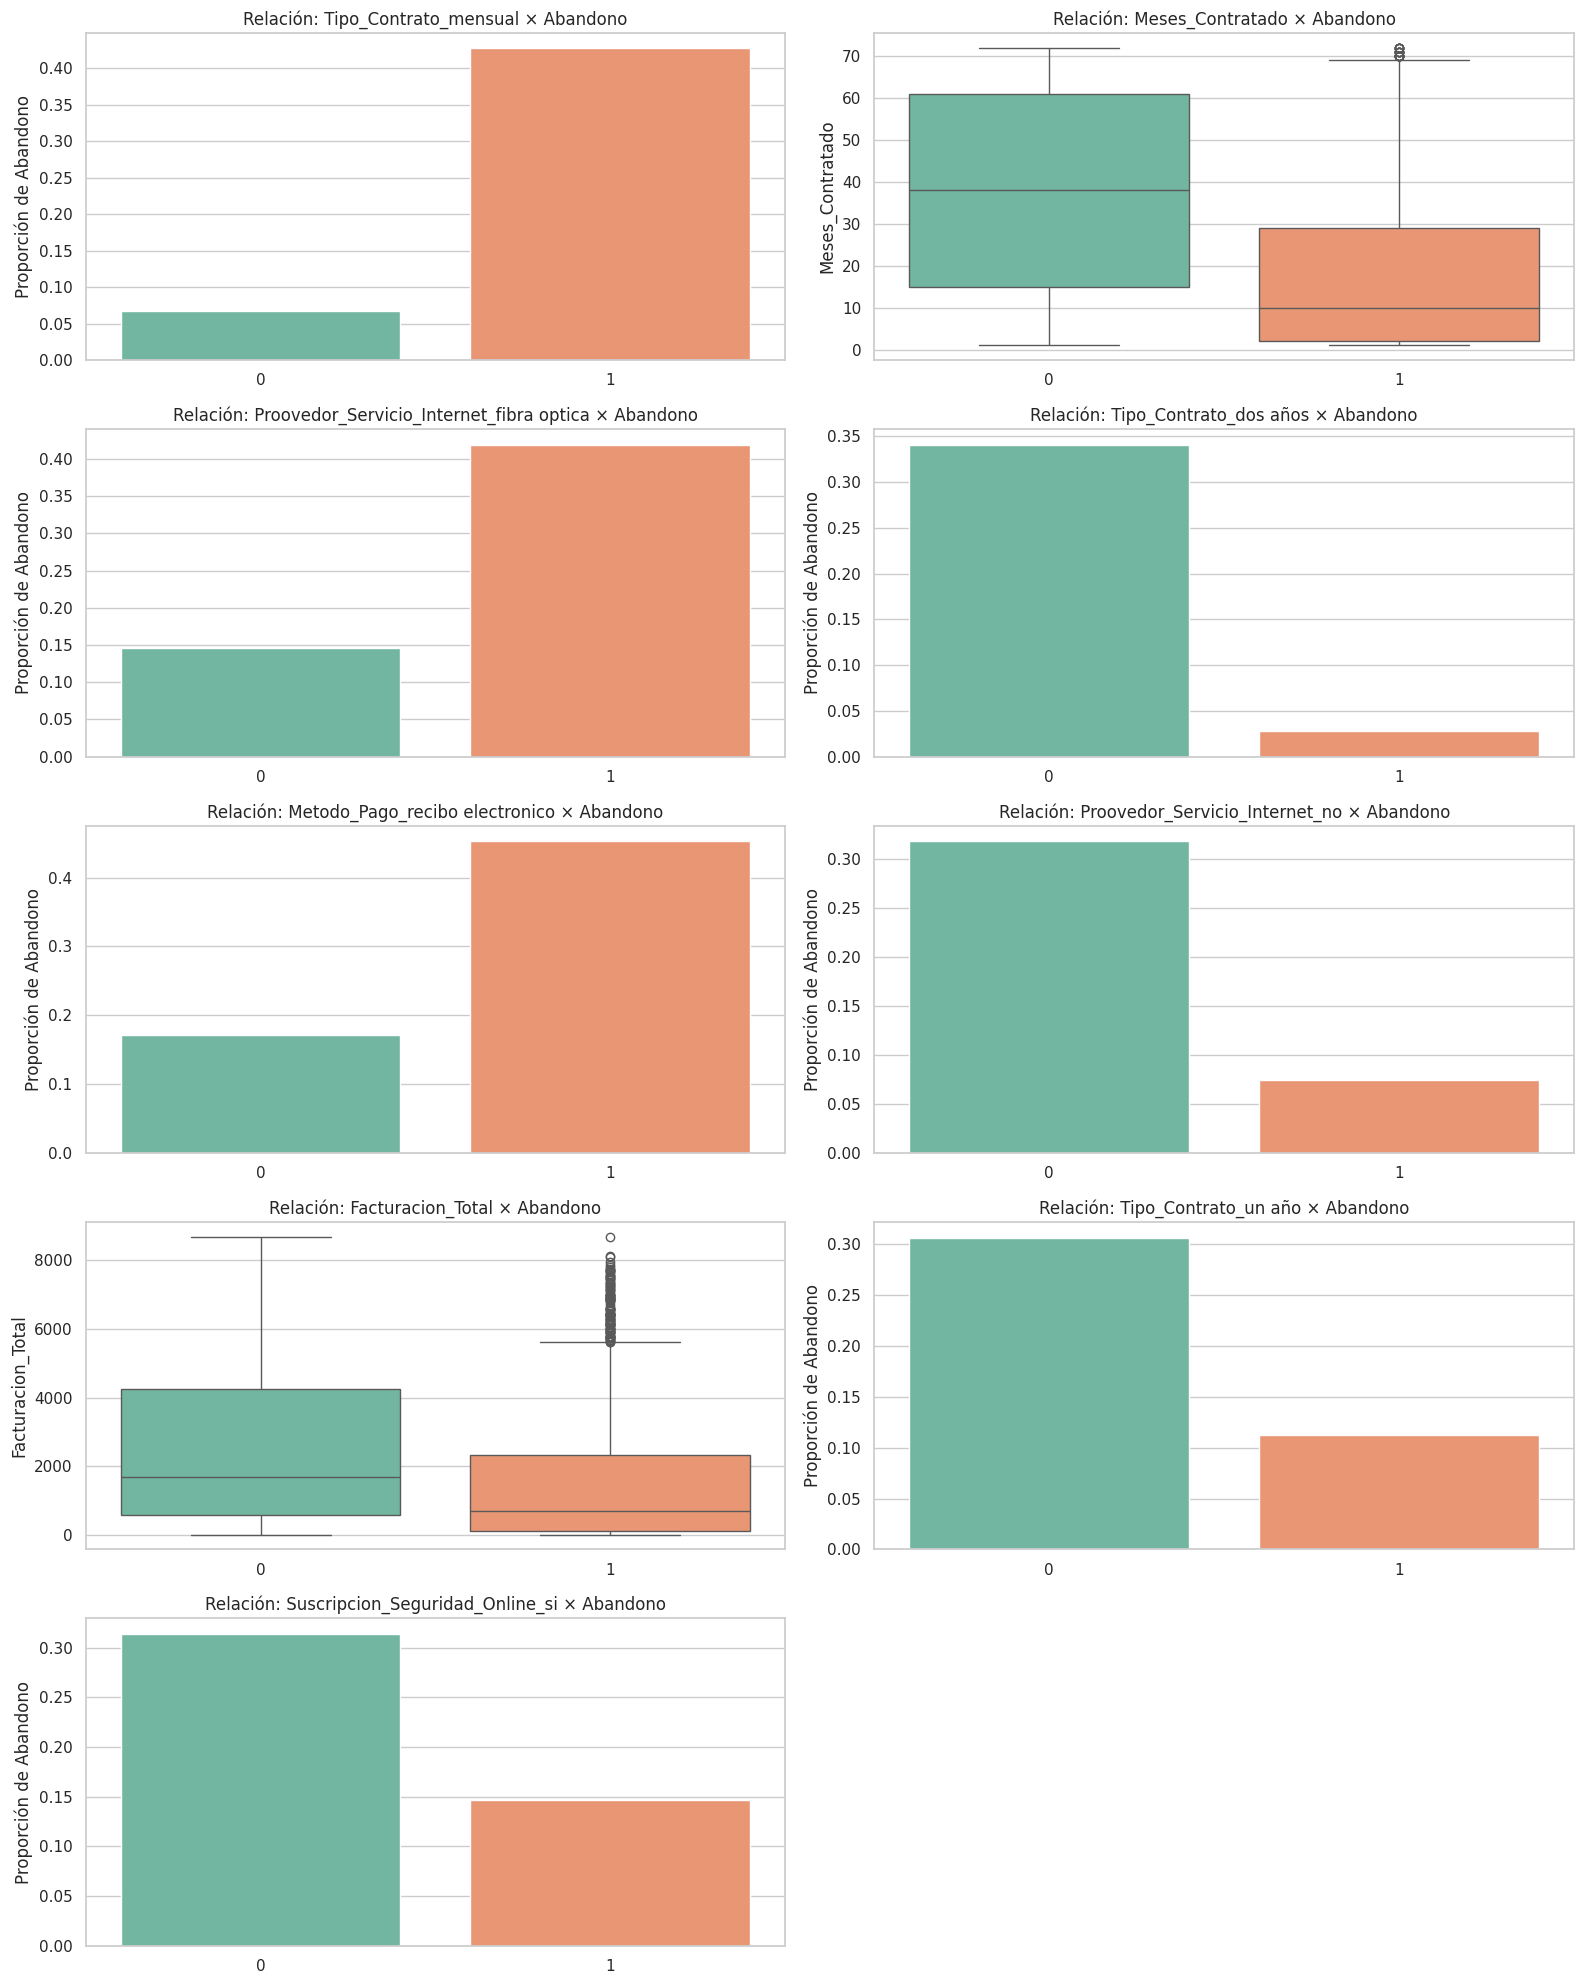

In [43]:


##Variables más correlacionadas con Abandono_si (excluyendo la propia Abandono_si)
vars_relevantes = [
    'Tipo_Contrato_mensual',
    'Meses_Contratado',
    'Proovedor_Servicio_Internet_fibra optica',
    'Tipo_Contrato_dos años',
    'Metodo_Pago_recibo electronico',
    'Proovedor_Servicio_Internet_no',
    'Facturacion_Total',
    'Tipo_Contrato_un año',
    'Suscripcion_Seguridad_Online_si'
]

sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

for i, col in enumerate(vars_relevantes, 1):
    plt.subplot(5, 2, i)

    if df_clientes_encoded[col].nunique() > 2:
        sns.boxplot(
            x='Abandono_si',
            y=col,
            data=df_clientes_encoded,
            hue='Abandono_si',
            palette='Set2',
            legend=False
        )
    else:
        churn_rate = df_clientes_encoded.groupby(col)['Abandono_si'].mean().reset_index()
        sns.barplot(
            x=col,
            y='Abandono_si',
            data=churn_rate,
            hue=col,
            palette='Set2',
            legend=False
        )
        plt.ylabel("Proporción de Abandono")

    plt.title(f"Relación: {col} × Abandono")
    plt.xlabel("")

plt.savefig("graficos_correlacion.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


#3. Modelado Predictivo

##Separación de datos

In [44]:


##Separar características y variable objetivo
X = df_clientes_encoded.drop(columns=['Abandono_si'])
y = df_clientes_encoded['Abandono_si']

##Dividir datos en entrenamiento (70%) y prueba (30%), manteniendo proporciones
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

##Confirmar tamaños y proporciones
print(f"Tamaño entrenamiento: {X_train.shape[0]} registros")
print(f"Tamaño prueba: {X_test.shape[0]} registros")
print("\nProporción en entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nProporción en prueba:")
print(y_test.value_counts(normalize=True))


Tamaño entrenamiento: 4922 registros
Tamaño prueba: 2110 registros

Proporción en entrenamiento:
Abandono_si
0    0.734254
1    0.265746
Name: proportion, dtype: float64

Proporción en prueba:
Abandono_si
0    0.734123
1    0.265877
Name: proportion, dtype: float64


##Creación de Modelos

In [45]:


##Modelo 1: Árbol de Decisión
dt_model = DecisionTreeClassifier(
    random_state=42
)
dt_model.fit(X_train, y_train)

##Modelo 2: Random Forest
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

print("Modelos entrenados correctamente.")


Modelos entrenados correctamente.


##Evaluación de los Modelos


Decision Tree (Optimizado) - Reporte de Clasificación:

              precision    recall  f1-score   support

           0     0.8289    0.9006    0.8632      1549
           1     0.6393    0.4866    0.5526       561

    accuracy                         0.7905      2110
   macro avg     0.7341    0.6936    0.7079      2110
weighted avg     0.7785    0.7905    0.7807      2110



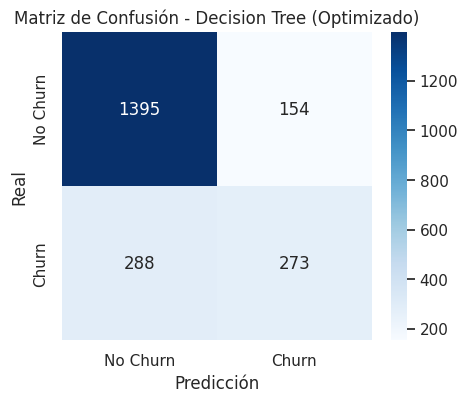


Random Forest (Optimizado) - Reporte de Clasificación:

              precision    recall  f1-score   support

           0     0.8351    0.8961    0.8645      1549
           1     0.6406    0.5116    0.5689       561

    accuracy                         0.7938      2110
   macro avg     0.7379    0.7038    0.7167      2110
weighted avg     0.7834    0.7938    0.7859      2110



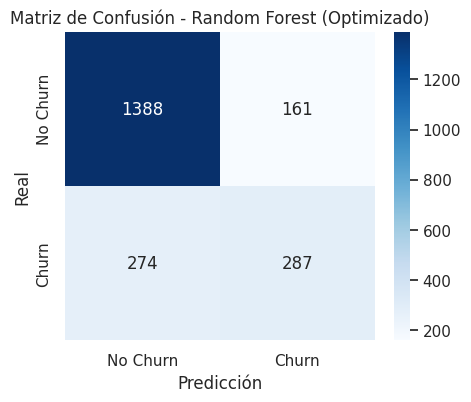


Comparativa de Modelos Optimizada:

                       Modelo  Accuracy  Precision    Recall  F1-Score
0  Decision Tree (Optimizado)  0.790521   0.639344  0.486631  0.552632
1  Random Forest (Optimizado)  0.793839   0.640625  0.511586  0.568880

Mejores parámetros Decision Tree: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejores parámetros Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [46]:



##GridSearch para Decision Tree
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_


##GridSearch para Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_params,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

##Evaluación de modelos optimizados
modelos_opt = {
    "Decision Tree (Optimizado)": best_dt,
    "Random Forest (Optimizado)": best_rf
}

resultados = []

for nombre, modelo in modelos_opt.items():
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append([nombre, acc, prec, rec, f1])

    print(f"\n{nombre} - Reporte de Clasificación:\n")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.show()


##Comparativa final
df_resultados_opt = pd.DataFrame(resultados, columns=["Modelo", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nComparativa de Modelos Optimizada:\n")
print(df_resultados_opt)

##Mostrar mejores parámetros encontrados
print("\nMejores parámetros Decision Tree:", dt_grid.best_params_)
print("Mejores parámetros Random Forest:", rf_grid.best_params_)


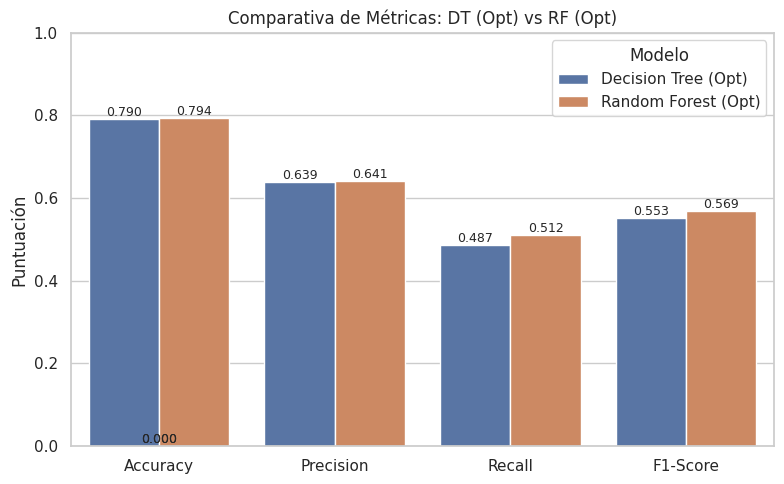

In [47]:



##Datos de métricas (usa los que obtuviste)
  #Métricas de Decision Tree (Optimizado)
dt_metrics = {
    "Accuracy": 0.7905,
    "Precision": 0.6393,
    "Recall": 0.4866,
    "F1-Score": 0.5526
}

  #Métricas de Random Forest (Optimizado)
rf_metrics = {
    "Accuracy": 0.7938,
    "Precision": 0.6406,
    "Recall": 0.5116,
    "F1-Score": 0.5689
}

##Construir DataFrame largo para graficar
  #Crear una lista de registros (métrica, modelo, valor)
records = []
for metric, val in dt_metrics.items():  # Recorre métricas de DT
    records.append({"Metrica": metric, "Modelo": "Decision Tree (Opt)", "Valor": val})
for metric, val in rf_metrics.items():  # Recorre métricas de RF
    records.append({"Metrica": metric, "Modelo": "Random Forest (Opt)", "Valor": val})

df_plot = pd.DataFrame(records)


##Dibujar gráfico de barras agrupadas y guardar
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

  #Barplot agrupado por 'Modelo' con 'Metrica' en el eje X
ax = sns.barplot(
    data=df_plot,
    x="Metrica",
    y="Valor",
    hue="Modelo",
    legend=True
)

ax.set_ylim(0, 1)
ax.set_title("Comparativa de Métricas: DT (Opt) vs RF (Opt)")
ax.set_xlabel("")
ax.set_ylabel("Puntuación")

  #Anotar los valores encima de cada barra con 3 decimales
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",
                (p.get_x() + p.get_width() / 2, height),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()

  #Guardar en PNG
plt.savefig("comparativa_metricas_modelos.png", dpi=300, bbox_inches="tight")
plt.show()


#4. Interpretación y Conclusiones

##Análisis de la importancia de las variables


Top 10 variables más importantes - Decision Tree:
                                    Variable  Importancia
16                     Tipo_Contrato_mensual     0.502354
7   Proovedor_Servicio_Internet_fibra optica     0.178469
22                          Meses_Contratado     0.158538
23                         Facturacion_Total     0.042648
19            Metodo_Pago_recibo electronico     0.030513
6            Proovedor_Servicio_Internet_dsl     0.026719
13                Suscripcion_StreamingTV_si     0.014973
1                             Es_Jubilado_si     0.009425
4                    Suscripcion_Telefono_si     0.007957
15                    Tipo_Contrato_dos años     0.006674


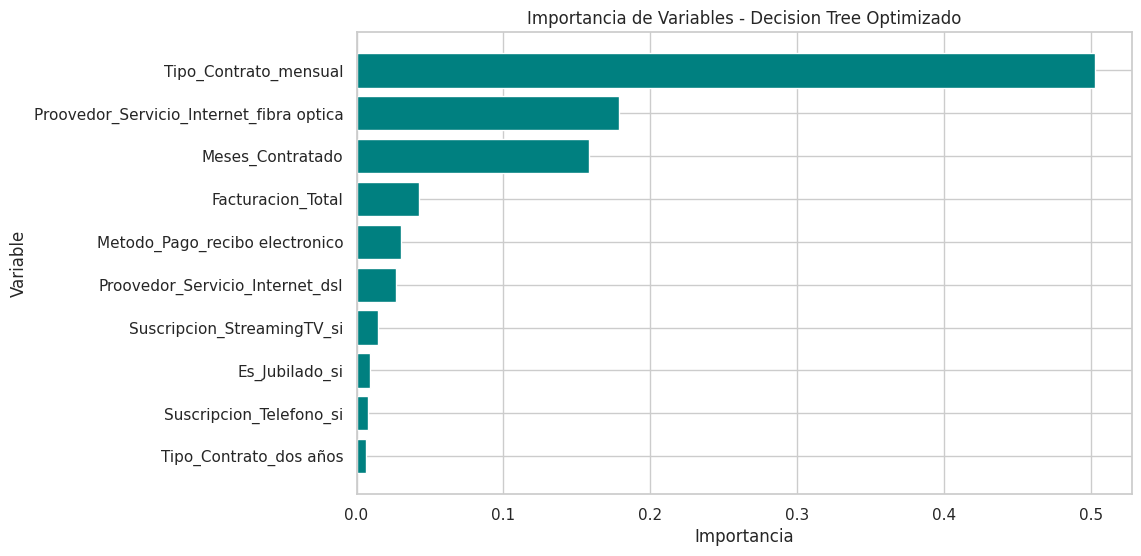

In [48]:


##Importancias del Decision Tree optimizado
importancias_dt = best_dt.feature_importances_

##Crear DataFrame con resultados
importancia_dt_df = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": importancias_dt
}).sort_values(by="Importancia", ascending=False)

##Seleccionar top 10
top_dt = importancia_dt_df.head(10)

##Mostrar resultados
print("Top 10 variables más importantes - Decision Tree:")
print(top_dt)

##Gráfico
plt.figure(figsize=(10,6))
plt.barh(top_dt["Variable"], top_dt["Importancia"], color="teal")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.title("Importancia de Variables - Decision Tree Optimizado")
plt.gca().invert_yaxis()

plt.savefig("variables_dt.png", dpi=300, bbox_inches="tight")
plt.show()


Top 10 variables más importantes:
                                    Variable  Importancia
22                          Meses_Contratado     0.172870
23                         Facturacion_Total     0.154444
16                     Tipo_Contrato_mensual     0.130032
7   Proovedor_Servicio_Internet_fibra optica     0.094860
19            Metodo_Pago_recibo electronico     0.067583
15                    Tipo_Contrato_dos años     0.048605
8             Proovedor_Servicio_Internet_no     0.041357
6            Proovedor_Servicio_Internet_dsl     0.025937
12            Suscripcion_Soporte_Tecnico_si     0.025758
9            Suscripcion_Seguridad_Online_si     0.024133


/tmp/ipython-input-4209855840.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=df_importancias.head(10), palette='viridis')


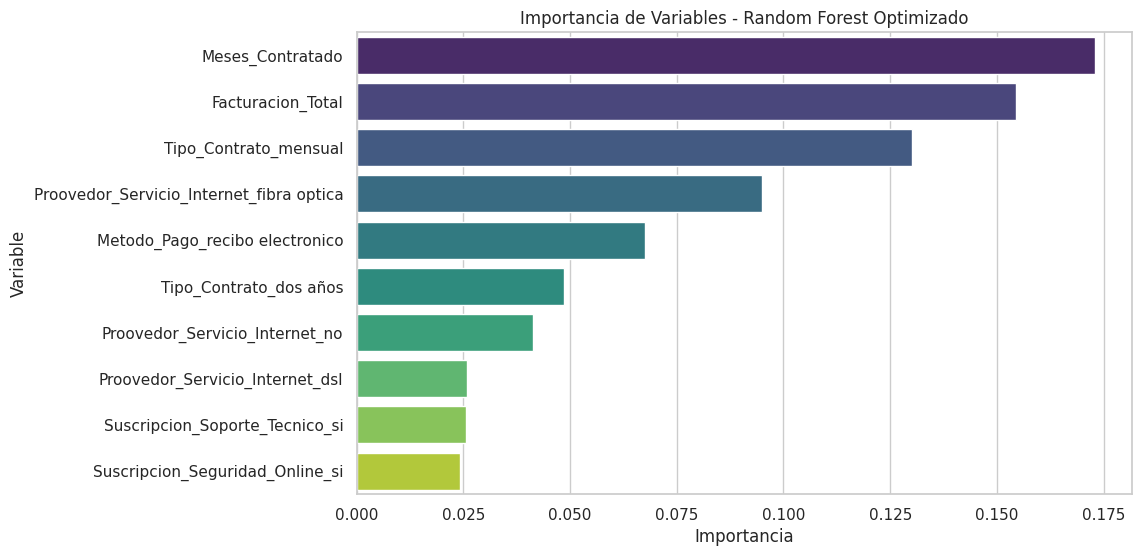

In [49]:


##Obtener importancias de variables del Random Forest optimizado
importancias = best_rf.feature_importances_

##Crear DataFrame ordenado
df_importancias = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

##Mostrar top 10
print("Top 10 variables más importantes:")
print(df_importancias.head(10))

##Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia', y='Variable', data=df_importancias.head(10), palette='viridis')
plt.title('Importancia de Variables - Random Forest Optimizado')
plt.xlabel('Importancia')
plt.ylabel('Variable')

plt.savefig("variables_rf.png", dpi=300, bbox_inches="tight")
plt.show()


##Conclusión

##Informe final

###**1. Principales hallazgos**

* **Random Forest** (Optimizado) mostró el mejor rendimiento general:

      Accuracy: 0.7938

      Precision (churn): 0.6406

      Recall (churn): 0.5116

      F1-Score (churn): 0.5689

    Es el **modelo más equilibrado** y robusto para generalizar patrones.

* **Decision Tree** (Optimizado) fue competitivo, pero más concentrado en pocas variables:

      Accuracy: 0.7905

      Precision (churn): 0.6393

      Recall (churn): 0.4866

      F1-Score (churn): 0.5526

    Es el **modelo más interpretable**, aunque más expuesto al **overfitting**.



[![comparativa-metricas-modelos.png](https://i.postimg.cc/3rkyhhfH/comparativa-metricas-modelos.png)](https://postimg.cc/14ZR0kZW)

###**2. Variables que más influyen en la cancelación**

* Según **Random Forest**:

    * **Meses_Contratado:** Clientes con pocos meses de servicio tienen mayor probabilidad de abandonar.

    * **Facturación_Total:** Montos más bajos (clientes nuevos o de bajo consumo) correlacionan con churn.

    * **Tipo_Contrato_mensual:** Los contratos mensuales presentan más riesgo que los de 1 o 2 años.

    * **Proveedor_Servicio_Internet_fibra óptica:** Usuarios de fibra óptica muestran tasas altas de abandono.

    * **Método_Pago_recibo electrónico:** Asociado con mayor probabilidad de churn.

[![variables-rf.png](https://i.postimg.cc/43MgbD6z/variables-rf.png)](https://postimg.cc/Z9r2JDDR)

* Según **Decision Tree**:

    * **Tipo_Contrato_mensual** (factor dominante con más del 50% de importancia).

    * **Proveedor_Servicio_Internet_fibra óptica**.

    * **Meses_Contratado**.

El árbol refuerza que **tipo de contrato** y **proveedor de internet** son críticos.

[![variables-dt.png](https://i.postimg.cc/B6KGhmpR/variables-dt.png)](https://postimg.cc/vgbjTLpv)

En **Random Forest**, la **importancia se distribuye más equilibradamente**, mientras que en **Decision Tree** una sola variable (contrato mensual) domina **más del 50% de la predicción**.

###**3. Interpretación de los resultados**

* **Clientes con contratos mensuales** tienen mucha mayor propensión al churn, ya que cuentan con mayor flexibilidad para irse.

* **Clientes con menos tiempo contratado** son más volátiles: la retención debe reforzarse en los primeros meses.

* **Facturación baja** puede reflejar clientes poco comprometidos, que consumen menos servicios y tienen menos barreras de salida.

* **Fibra óptica** aparece como un factor de riesgo, posiblemente porque es un segmento con más competencia o mayores expectativas de calidad.

* **Método de pago electrónico** puede estar asociado a clientes más recientes o menos fidelizados.

[![graficos-correlacion.png](https://i.postimg.cc/6pr2Phj2/graficos-correlacion.png)](https://postimg.cc/JshzDjWM)

###**4. Estrategias de retención propuestas**

✒️ **Incentivar contratos anuales o bianuales** mediante descuentos, beneficios exclusivos o programas de fidelización.

🖖 **Campañas de onboarding y retención en los primeros 6 meses**, reforzando la experiencia de usuario y la calidad del servicio.

💲 **Promociones personalizadas para clientes de bajo consumo**, como paquetes combinados o servicios adicionales con costo reducido.

👌 **Mejorar la experiencia de usuarios de fibra óptica**, con atención técnica prioritaria, soporte proactivo y monitoreo de calidad.

💸 **Optimizar métodos de pago**: incentivar pagos automáticos con recompensas, reduciendo fricción y aumentando compromiso.

###**Conclusión general**

El abandono o churn está fuertemente asociado al **tipo de contrato**, la **antigüedad del cliente** y el **monto facturado**. **Random Forest** es el modelo más confiable para predecir cancelación, mientras que Decision Tree facilita la interpretación al señalar que los contratos mensuales son el mayor factor de riesgo.



**Nota:** el recall de churn aún es bajo (~50%), lo que significa que el modelo todavía falla en detectar a la mitad de clientes que realmente se van. Se recomienda probar modelos más avanzados (XGBoost, LightGBM, redes neuronales) y explorar el balanceo de clases (SMOTE, undersampling) para mejorar la detección de churn.